## Necessary Libraries

In [15]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.model_selection import KFold

from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import json

# ingnore future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Load Data

In [16]:
cuisine_df =pd.read_csv('RAW_recipes_with_one_cuisine.csv')

In [17]:
cuisine_df.head()

,name,id,minutes,contributor_id,submitted,tags,nutrition,n_steps,steps,description,ingredients,n_ingredients,Cuisine_Tags
0,arriba baked winter squash mexican style,137739,55,47892,2005-09-16,"['60-minutes-or-less', 'time-to-make', 'course...","[51.5, 0.0, 13.0, 0.0, 2.0, 0.0, 4.0]",11,"['make a choice and proceed with recipe', 'dep...",autumn is my favorite time of year to cook! th...,"['winter squash', 'mexican seasoning', 'mixed ...",7,['mexican']
1,a bit different breakfast pizza,31490,30,26278,2002-06-17,"['30-minutes-or-less', 'time-to-make', 'course...","[173.4, 18.0, 0.0, 17.0, 22.0, 35.0, 1.0]",9,"['preheat oven to 425 degrees f', 'press dough...",this recipe calls for the crust to be prebaked...,"['prepared pizza crust', 'sausage patty', 'egg...",6,['northeastern-united-states']
2,amish tomato ketchup for canning,44061,190,41706,2002-10-25,"['weeknight', 'time-to-make', 'course', 'main-...","[352.9, 1.0, 337.0, 23.0, 3.0, 0.0, 28.0]",5,['mix all ingredients& boil for 2 1 / 2 hours ...,my dh's amish mother raised him on this recipe...,"['tomato juice', 'apple cider vinegar', 'sugar...",8,['northeastern-united-states']
3,aww marinated olives,25274,15,21730,2002-04-14,"['15-minutes-or-less', 'time-to-make', 'course...","[380.7, 53.0, 7.0, 24.0, 6.0, 24.0, 6.0]",4,['toast the fennel seeds and lightly crush the...,my italian mil was thoroughly impressed by my ...,"['fennel seed', 'green olive', 'ripe olive', '...",9,['canadian']
4,chile rellenos,43026,45,52268,2002-10-14,"['60-minutes-or-less', 'time-to-make', 'course...","[94.0, 10.0, 0.0, 11.0, 11.0, 21.0, 0.0]",9,"['drain green chiles', 'sprinkle cornstarch on...",a favorite from a local restaurant no longer i...,"['egg roll wrap', 'whole green chili', 'cheese...",5,['southwestern-united-states']


In [18]:
import ast

def convert_to_list(tags_str):
    try:
        return ast.literal_eval(tags_str)
    except (ValueError, SyntaxError):
        return []

In [19]:
cuisine_df['ingredients']=cuisine_df['ingredients'].apply(convert_to_list)
cuisine_df['Cuisine_Tags']=cuisine_df['Cuisine_Tags'].apply(convert_to_list)

In [20]:
# Join ingredients lists into strings
cuisine_df['ingredients_str'] = cuisine_df['ingredients'].apply(lambda x: ' '.join(x))
cuisine_df['Cuisine_Tags_str']= cuisine_df['Cuisine_Tags'].apply(lambda x: ' '.join(x))

In [21]:
cuisine_df.ingredients_str[10]

'fettuccine pasta cheddar cheese soup milk picante sauce black olive jalapeno'

## Process Data

In [22]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cuisine_Tags_str']

## Split Data

In [23]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [24]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

## Cross-Validation for Models

In [25]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

## Plots Performance

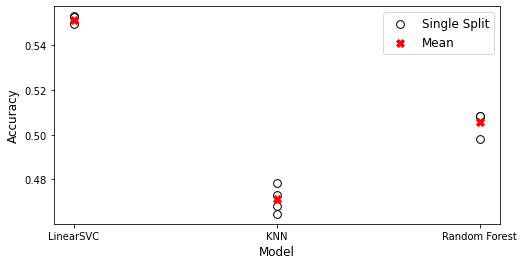

In [26]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

## Testing Models on Test Data

In [27]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.5572420634920635

In [28]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.47867063492063494

In [29]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.5197420634920635

## Deciding on Minimal Clustering of Cuisines

In [50]:
# Verify the content of the JSON file
with open('cuisine_clusters30.json', 'r') as f:
    clusters30 = json.load(f)

In [51]:
# Create a reverse mapping from cuisine to cluster number
cuisine_to_cluster30 = {cuisine: cluster for cluster, cuisines in clusters30.items() for cuisine in cuisines}

In [52]:
# Function to map each cuisine tag to its cluster number
def get_cluster_number(cuisine_tags):
    return cuisine_to_cluster30.get(cuisine_tags[0], None)  # Assuming each cuisine tag is a single-item list

In [53]:
# Apply the function to create a new column with cluster numbers
cuisine_df['Clusters'] = cuisine_df['Cuisine_Tags'].apply(get_cluster_number)

In [54]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Clusters']

In [55]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [56]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

In [57]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

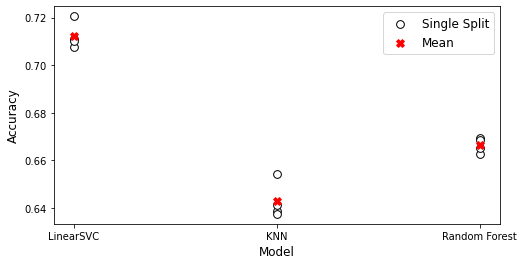

In [58]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

In [59]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.718452380952381

In [60]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.6455357142857143

In [61]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.6808531746031746

In [62]:
# Verify the content of the JSON file
with open('cuisine_clusters20.json', 'r') as f:
    clusters20 = json.load(f)

In [63]:
# Create a reverse mapping from cuisine to cluster number
cuisine_to_cluster20 = {cuisine: cluster for cluster, cuisines in clusters20.items() for cuisine in cuisines}

In [64]:
# Function to map each cuisine tag to its cluster number
def get_cluster_number(cuisine_tags):
    return cuisine_to_cluster20.get(cuisine_tags[0], None)  # Assuming each cuisine tag is a single-item list

In [65]:
# Apply the function to create a new column with cluster numbers
cuisine_df['Cluster'] = cuisine_df['Cuisine_Tags'].apply(get_cluster_number)

In [66]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [67]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [68]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [69]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

In [70]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

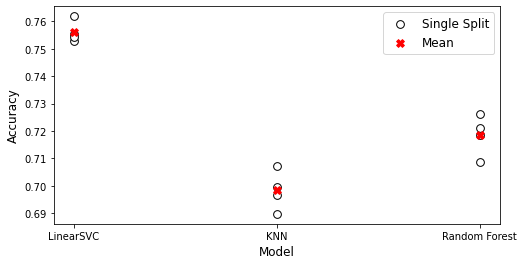

In [71]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

In [72]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.7614087301587301

In [73]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.7003968253968254

In [74]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.7277777777777777

In [75]:
# Verify the content of the JSON file
with open('cuisine_clusters15.json', 'r') as f:
    clusters15 = json.load(f)

In [76]:
# Create a reverse mapping from cuisine to cluster number
cuisine_to_cluster15 = {cuisine: cluster for cluster, cuisines in clusters15.items() for cuisine in cuisines}

In [77]:
# Function to map each cuisine tag to its cluster number
def get_cluster_number(cuisine_tags):
    return cuisine_to_cluster15.get(cuisine_tags[0], None)  # Assuming each cuisine tag is a single-item list

In [78]:
# Apply the function to create a new column with cluster numbers
cuisine_df['Cluster'] = cuisine_df['Cuisine_Tags'].apply(get_cluster_number)

In [79]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [80]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [81]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [82]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

In [83]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

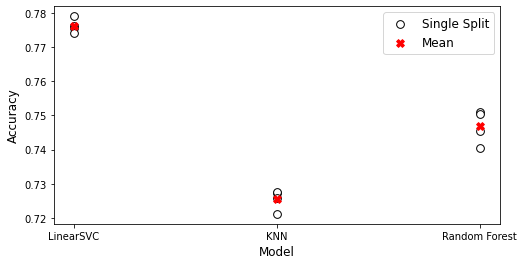

In [84]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

In [85]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.7863095238095238

In [86]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.7296626984126984

In [87]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.7569444444444444

In [88]:
# Verify the content of the JSON file
with open('cuisine_clusters10.json', 'r') as f:
    clusters10 = json.load(f)

In [89]:
# Create a reverse mapping from cuisine to cluster number
cuisine_to_cluster10 = {cuisine: cluster for cluster, cuisines in clusters10.items() for cuisine in cuisines}

In [90]:
# Function to map each cuisine tag to its cluster number
def get_cluster_number(cuisine_tags):
    return cuisine_to_cluster10.get(cuisine_tags[0], None)  # Assuming each cuisine tag is a single-item list

In [91]:
# Apply the function to create a new column with cluster numbers
cuisine_df['Cluster'] = cuisine_df['Cuisine_Tags'].apply(get_cluster_number)

In [92]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [93]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [94]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [95]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

In [96]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

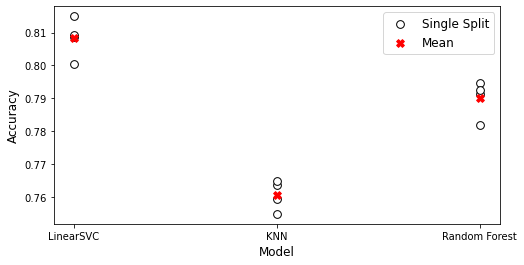

In [97]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

In [98]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.8168650793650793

In [99]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.7655753968253968

In [100]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.7999007936507937

In [101]:
# Verify the content of the JSON file
with open('cuisine_clusters5.json', 'r') as f:
    clusters5 = json.load(f)

In [102]:
# Create a reverse mapping from cuisine to cluster number
cuisine_to_cluster5 = {cuisine: cluster for cluster, cuisines in clusters5.items() for cuisine in cuisines}

In [103]:
# Function to map each cuisine tag to its cluster number
def get_cluster_number(cuisine_tags):
    return cuisine_to_cluster5.get(cuisine_tags[0], None)  # Assuming each cuisine tag is a single-item list

In [104]:
# Apply the function to create a new column with cluster numbers
cuisine_df['Cluster'] = cuisine_df['Cuisine_Tags'].apply(get_cluster_number)

In [105]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [106]:
# Convert text data to TF-IDF features
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(cuisine_df['ingredients_str'])
y = cuisine_df['Cluster']

In [107]:
# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=614)

In [108]:
# Kfold split
kfold = KFold(n_splits = 4,
              shuffle = True)

In [109]:
# Store the accuracy
acc = np.zeros((3, 4))

# Keeps track of the split
i = 0
for train_index, test_index in kfold.split(X_train, y_train):
    ## Creates training split on the training set
    X_train_train = X_train[train_index,:]
    y_train_train = y_train.iloc[train_index]
    
    ## Creates holdout data for testing
    X_holdout = X_train[test_index,:]
    y_holdout = y_train.iloc[test_index]
    
    # Model 1 - LinearSVC
    model_1 = LinearSVC(dual = False)
    model_1.fit(X_train_train, y_train_train)
    y_holdout_predict_1 = model_1.predict(X_holdout)
    
    #Store Accuracy
    acc[0,i] = accuracy_score(y_holdout, y_holdout_predict_1)
    
    # Model 2 - KNN
    model_2 = KNeighborsClassifier()
    model_2.fit(X_train_train, y_train_train)
    y_holdout_predict_2 = model_2.predict(X_holdout)
    
    # Store Accuracy
    acc[1,i] = accuracy_score(y_holdout, y_holdout_predict_2)
    
    # Model 3 - Random Forest
    model_3 = RandomForestClassifier()
    model_3.fit(X_train_train, y_train_train)
    y_holdout_predict_3 = model_3.predict(X_holdout)
    
    # Store Accuracy
    acc[2,i] = accuracy_score(y_holdout, y_holdout_predict_3)
    
    # Moves onto the next split
    i = i + 1

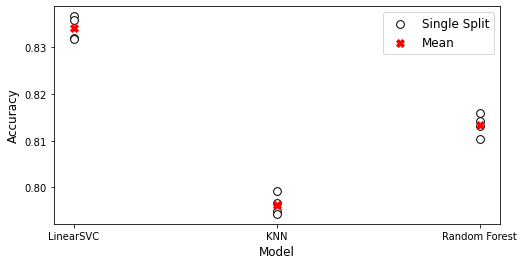

In [110]:
## Figure to compare the performances
plt.figure(figsize=(8,4))

# Plots LinearSVC
plt.scatter(np.zeros(4), 
            acc[0,:], 
            s=60, 
            c='white',
            edgecolor='black',
            label="Single Split")

# Plots KNN
plt.scatter(np.ones(4), 
            acc[1,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Random Forest
plt.scatter(2*np.ones(4), 
            acc[2,:], 
            s=60, 
            c='white',
            edgecolor='black')

# Plots Average
plt.scatter([0,1,2], 
            np.mean(acc, axis=1), 
            s=60, 
            c='r',
            marker='X',
            label="Mean")

# Creates Legend
plt.legend(fontsize=12)

# Labels Ticks
plt.xticks([0,1,2],["LinearSVC","KNN", "Random Forest"], fontsize=10)
plt.yticks(fontsize=10)

#Labels Graphs
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)

# Plots Graph
plt.show()

In [111]:
y_predict=model_1.predict(X_test)
accuracy_score(y_test, y_predict)

0.8419642857142857

In [112]:
y_predict=model_2.predict(X_test)
accuracy_score(y_test, y_predict)

0.8034722222222223

In [113]:
y_predict=model_3.predict(X_test)
accuracy_score(y_test, y_predict)

0.8279761904761904